## Define networks

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
import csv

class RNN(nn.Module):
    def __init__(self, input_dim=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, 50, 1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        try:
            out, self.h = self.rnn(x, self.h)
        except Exception:
            self.h = Variable(torch.zeros(1, x.size(0), 50), requires_grad=False).cuda()
            out, self.h = self.rnn(x, self.h)
        self.h = Variable(self.h.data).cuda()
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out

class ANN(nn.Module):
    def __init__(self, input_size=100, bias=True):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size//2, bias=bias)
        self.fc2 = nn.Linear(input_size//2, 1, bias=bias)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

class LSTM(nn.Module):
    def __init__(self, input_dim=1):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, 50, 1, dropout=0.2, batch_first=True)
        self.lstm2 = nn.LSTM(50, 100, 1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(100, 1)
        
    def forward(self, x):
        try:
            out, self.h1 = self.lstm1(x, self.h1)
        except Exception:
            self.h1 = (Variable(torch.zeros(1, x.size(0), 50), requires_grad=False).cuda(),
                       Variable(torch.zeros(1, x.size(0), 50), requires_grad=False).cuda())
            out, self.h1 = self.lstm1(x, self.h1)
        self.h1 = (Variable(self.h1[0].data, requires_grad=False).cuda(),
                   Variable(self.h1[1].data, requires_grad=False).cuda())

        try:
            out, self.h2 = self.lstm2(out, self.h2)
        except Exception:
            self.h2 = (Variable(torch.zeros(1, x.size(0), 100), requires_grad=False).cuda(),
                       Variable(torch.zeros(1, x.size(0), 100), requires_grad=False).cuda())
            out, self.h2 = self.lstm2(out, self.h2)
        self.h2 = (Variable(self.h2[0].data, requires_grad=False).cuda(),
                   Variable(self.h2[1].data, requires_grad=False).cuda())
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out

### LSTM no hidden state

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_dim=1):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, 50, 1, dropout=0.2, batch_first=True)
        self.lstm2 = nn.LSTM(50, 100, 1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(100, 1)
        
    def forward(self, x):
        out, _ = self.lstm1(x, None)
        out = F.relu(out)
        out, _ = self.lstm2(out, None)
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out

## Prepare dataset

In [3]:
input_size = 2
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
data = []
for row in file:
    if len(row[0]) == 16:
        data.append(float(row[5]))
        
data_delta = []
for i in range(len(data)-1):
    data_delta.append(data[i+1]-data[i])
data = data_delta

end_point = 4680
# data = (data - np.mean(data))/np.max(np.abs(data))
x = torch.Tensor(end_point - input_size, input_size)
y = torch.Tensor(end_point - input_size, 1)
for step in range(end_point - input_size):
    sequence = np.array(data[step : step + input_size + 1])
    sequence = (sequence - np.mean(sequence[:-1]))/np.max(np.abs(sequence[:-1]))
    x[step, :] = torch.from_numpy(sequence[:-1])
    y[step, :] = torch.FloatTensor([sequence[-1]])
train_set = torch.utils.data.TensorDataset(x, y)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


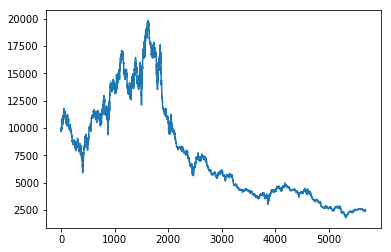

5680


In [73]:
plt.plot(data)
plt.show()
print(len(data))

## LSTM

In [4]:
input_dim = 1
model = LSTM(input_dim)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)
loss_func = nn.MSELoss()
epoch = 0
while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda().float()
        if input_dim == 1:
            inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
        else:
            inputs, targets = Variable(inputs).view(-1, 1, input_dim), Variable(targets)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    if epoch % 10 == 9:
        print('epoch: ', epoch + 1)
        print('loss: ', train_loss)
    epoch += 1

epoch:  10
loss:  0.00046986230331271683
epoch:  20
loss:  0.0004667968275277196
Epoch    29: reducing learning rate of group 0 to 1.0000e-02.
epoch:  30
loss:  0.0004698724967326868
epoch:  40
loss:  0.0004678699691352007
epoch:  50
loss:  0.00047151721239945774
Epoch    52: reducing learning rate of group 0 to 1.0000e-03.
epoch:  60
loss:  0.00047118060300252527
Epoch    63: reducing learning rate of group 0 to 1.0000e-04.
epoch:  70
loss:  0.0004668607513382527
Epoch    74: reducing learning rate of group 0 to 1.0000e-05.
epoch:  80
loss:  0.0004687519206011013
Epoch    85: reducing learning rate of group 0 to 1.0000e-06.


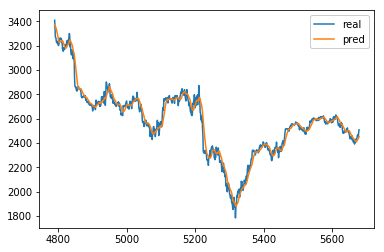

In [5]:
pred = []
error = []
start_point = 4780
test_data = data[start_point:]
for step in range(len(test_data)-input_size):
    seq = np.array(test_data[step : step+input_size+1])
    avg_seq = np.mean(seq)
    max_seq = np.max(np.abs(sequence))
    seq = (seq - avg_seq)/max_seq

    x_np = seq[:-1]
    y_np = seq[-1]

    if input_dim == 1:
        x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    else:
        x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(range(start_point+input_size, len(data)), test_data[input_size:], label='real')
plt.plot(range(start_point+input_size, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [6]:
np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])

2039.6774232366047

In [ ]:
plt.plot(test_data[-100:], label='real')
plt.plot(pred[-100:], label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

## RNN

In [4]:
input_dim = 1
model = RNN(input_dim)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)
loss_func = nn.MSELoss()
epoch = 0
while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda().float()
        if input_dim == 1:
            inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
        else:
            inputs, targets = Variable(inputs).view(-1, 1, input_dim), Variable(targets)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    if epoch % 10 == 9:
        print('epoch: ', epoch + 1)
        print('loss: ', train_loss)
    epoch += 1

epoch:  10
loss:  0.0004738110693398158
epoch:  20
loss:  0.0004666144912433181
epoch:  30
loss:  0.00046706323297946036
epoch:  40
loss:  0.000458038439565162
epoch:  50
loss:  0.0004559382056892925
epoch:  60
loss:  0.00044713439844624216
epoch:  70
loss:  0.0004438744335611527
epoch:  80
loss:  0.0004383129393367248
epoch:  90
loss:  0.0004366741868088374
epoch:  100
loss:  0.00043066762068396985
epoch:  110
loss:  0.000426532540980072
epoch:  120
loss:  0.00042141011107486447
epoch:  130
loss:  0.0004180226265767438
epoch:  140
loss:  0.00041496371409880956
epoch:  150
loss:  0.0004088169992649676
epoch:  160
loss:  0.00040533500833663384
epoch:  170
loss:  0.0004004628847453844
epoch:  180
loss:  0.0004010924682449046
epoch:  190
loss:  0.00039298013065048064
epoch:  200
loss:  0.0003897853068239685
epoch:  210
loss:  0.00038639822820629423
epoch:  220
loss:  0.0003785384980949095
epoch:  230
loss:  0.00037374719269447833
epoch:  240
loss:  0.00036900921219745904
epoch:  250
loss:

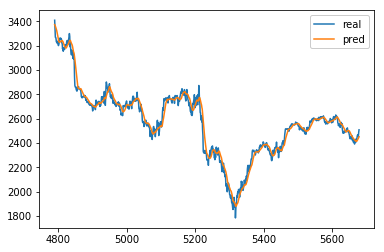

In [5]:
pred = []
error = []
start_point = 4780
test_data = data[start_point:]
for step in range(len(test_data)-input_size):
    seq = np.array(test_data[step : step+input_size+1])
    avg_seq = np.mean(seq)
    max_seq = np.max(np.abs(sequence))
    seq = (seq - avg_seq)/max_seq

    x_np = seq[:-1]
    y_np = seq[-1]

    if input_dim == 1:
        x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    else:
        x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(range(start_point+input_size, len(data)), test_data[input_size:], label='real')
plt.plot(range(start_point+input_size, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [6]:
np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])

2037.9903943562754

In [ ]:
plt.plot(test_data[-100:], label='real')
plt.plot(pred[-100:], label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

## ANN

In [81]:
input_size = 5
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
data = []
for row in file:
    if len(row[0]) == 16:
        data.append(float(row[5]))

# data_delta = []
# for i in range(len(data)-1):
#     data_delta.append(data[i+1]-data[i])
# data = data_delta

end_point = 4680
# data = (data - np.mean(data))/np.max(np.abs(data))
x = torch.Tensor(end_point - input_size, input_size)
y = torch.Tensor(end_point - input_size, 1)
for step in range(end_point - input_size):
    sequence = np.array(data[step : step + input_size + 1])
    sequence = (sequence - np.mean(sequence[:-1]))
    x[step, :] = torch.from_numpy(sequence[:-1])
    y[step, :] = torch.FloatTensor([sequence[-1]])
max_seq = torch.max(x.abs())
x = x / max_seq
y = y / max_seq
train_set = torch.utils.data.TensorDataset(x, y)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

In [46]:
model = ANN(input_size)
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)
loss_func = nn.MSELoss()
epoch = 0
while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda().float()
        inputs, targets = Variable(inputs).view(-1, inputs.size(1)), Variable(targets)
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    if epoch % 10 == 9:
        print('epoch: ', epoch + 1)
        print('loss: ', train_loss)
    epoch += 1

epoch:  10
loss:  0.00023134447660964183
epoch:  20
loss:  0.00023119744720453446
Epoch    25: reducing learning rate of group 0 to 1.0000e-02.
epoch:  30
loss:  0.00023184944458645642
Epoch    36: reducing learning rate of group 0 to 1.0000e-03.
epoch:  40
loss:  0.00023164274170994759
Epoch    47: reducing learning rate of group 0 to 1.0000e-04.
epoch:  50
loss:  0.000231487445833753
Epoch    58: reducing learning rate of group 0 to 1.0000e-05.


In [53]:
sequence

array([-0.00160776,  0.00160776, -0.01449665])

ValueError: x and y must have same first dimension, but have shapes (992,) and (895,)

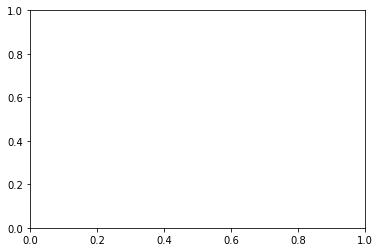

In [111]:
pred = []
error = []
start_point = 4780
test_data = data[start_point:]
for step in range(len(test_data)-input_size):
    seq = np.array(test_data[step : step+input_size+1])
    avg_seq = np.mean(seq[:-1])
    max_seq = np.max(np.abs(seq[:-1]))
    seq = (seq - avg_seq)/max_seq

    x_np = seq[:-1]
    y_np = seq[-1]
    x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(range(start_point+input_size, len(data)), test_data[input_size:], label='real')
plt.plot(range(start_point+input_size, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [87]:
np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])

888.0993238891045

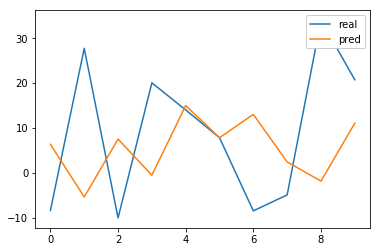

In [88]:
plt.plot(test_data[-10:], label='real')
plt.plot(pred[-10:], label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [198]:
for input_size in [2, 3, 5, 10, 20, 30, 50, 70, 100]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
    data1 = []
    for row in file:
        if len(row[0]) == 16:
            data1.append(float(row[5]))

    file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
    data2 = []
    for row in file:
        if len(row[0]) == 16:
            data2.append(float(row[5]))

    data_delta = []
    for i in range(len(data1)-1):
        data_delta.append(data1[i+1]-data1[i])
    data1 = data_delta

    data_delta = []
    for i in range(len(data2)-1):
        data_delta.append(data2[i+1]-data2[i])
    data2 = data_delta

    end_point = len(data1)-1000

#     # one dimension
#     data = data1
#     x = torch.Tensor(end_point - input_size, input_size)
#     y = torch.Tensor(end_point - input_size, 1)
#     avg_seq = np.mean(data[:end_point])
#     max_seq = np.max(np.abs(data[:end_point]))
#     for step in range(end_point - input_size):
#         sequence = np.array(data[step : step + input_size + 1])
#         x[step, :] = torch.from_numpy(sequence[:-1])
#         y[step, :] = torch.FloatTensor([sequence[-1]])
    
#     x = (x - avg_seq) / max_seq
#     y = (y - avg_seq) / max_seq

    # two dimensions
    x = torch.Tensor(end_point - input_size, input_size*2)
    y = torch.Tensor(end_point - input_size, 1)
    avg1_seq = np.mean(data1[:end_point])
    max1_seq = np.max(np.abs(data1[:end_point]))

    avg2_seq = np.mean(data2[:end_point])
    max2_seq = np.max(np.abs(data2[:end_point]))
    for step in range(end_point - input_size):
        sequence = np.concatenate(((np.array(data1[step : step + input_size])-avg1_seq)/max1_seq,
                                   (np.array(data2[step : step + input_size])-avg2_seq)/max2_seq))
        x[step, :] = torch.from_numpy(sequence)
        y[step, :] = torch.FloatTensor([data1[step+input_size]])
    y = (y - avg1_seq) / max1_seq

    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    model = ANN(input_size*2)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs).view(-1, inputs.size(1)), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
        train_loss /= len(train_loader)
        scheduler.step(train_loss)
        print(train_loss)
        epoch += 1
    pred = []
    error = []
    start_point = end_point + input_size
#     test_data = data[start_point:]
    test_data1 = data1[start_point:]
    test_data2 = data2[start_point:]
    for step in range(len(test_data1)-input_size):
#         seq = np.array(test_data[step : step+input_size+1])
#         seq = (seq - avg_seq)/max_seq

        x_np = np.concatenate(((np.array(test_data1[step : step + input_size])-avg1_seq)/max1_seq,
                               (np.array(test_data2[step : step + input_size])-avg2_seq)/max2_seq))
#         x_np = seq[:-1]
#         y_np = seq[-1]

        y_np = (np.array(test_data1[step+input_size]) - avg1_seq)/max1_seq
        x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        pred.append(avg1_seq+max1_seq*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.mean([np.power(a-b, 2) for a, b in zip(test_data1[input_size:], pred)]))


==> input_length:  2
0.008961184115972944
0.007833171641836181
0.007847730153932786
0.007795644518083487
0.008038243828102564
0.008020713704471022
0.0077842675733009875
0.007962143753106013
0.007882133305359345
0.007763352721201208
0.00858661545536075
0.007771855476909341
0.007759976063449032
0.007759047752747742
0.007996060007896561
0.00779020481217557
0.007808299269527197
0.0077454399687644
0.007791379878584009
0.00784582562911778
0.007846052531535044
0.007762572919137967
0.007806727340301642
0.007760150781952036
0.007742222076138625
0.007822893374862198
0.007734019145106849
0.008072441849762049
0.007744668727704825
0.00772861573466052
0.0077344173511776785
0.007710916898735703
0.007716715682106905
0.007888088408762064
0.007729880858021669
0.007890286968829922
0.008005468855397059
0.00773063193833551
0.007958732461795593
0.00784769039362287
0.0077067830481190374
0.007711805670390813
0.007706660693750167
0.00940106199003565
0.008032814850314306
0.007794603114374555
0.0077333562344742

Process Process-110194:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process Process-110193:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt



==> input_length:  30
==> train_error 124.32061788574008
==> error:  113.46237566917067


AttributeError: Unknown property lebel

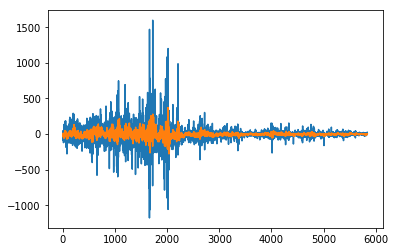

In [343]:
for input_size in [30]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
    data1 = []
    for row in file:
        if len(row[0]) == 16:
            data1.append((float(row[3]) + float(row[4]))/2)

    data_delta = []
    for i in range(len(data1)-1):
        data_delta.append(data1[i+1]-data1[i])
    data1 = data_delta


    file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
    data2 = []
    for row in file:
        if len(row[0]) == 16:
            data2.append((float(row[3]) + float(row[4]))/2)
    end_point = len(data1)-1000

    data_delta = []
    for i in range(len(data2)-1):
        data_delta.append(data2[i+1]-data2[i])
    data2 = data_delta

    # one dimension
    data = data1
    x = torch.Tensor(end_point - input_size, input_size)
    x2 = torch.Tensor(end_point - input_size, input_size)
    y = torch.Tensor(end_point - input_size, 1)
    for step in range(end_point - input_size):
        sequence = np.array(data[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x[step, :] = torch.from_numpy(sequence[:-1])
        y[step, :] = torch.FloatTensor([sequence[-1]])
#     for step in range(end_point - input_size):
#         sequence = np.array(data2[step : step + input_size + 1])
#         sequence = (sequence - np.mean(sequence[:-1]))
#         x2[step, :] = torch.from_numpy(sequence[:-1])
#         y[step, :] = torch.FloatTensor([sequence[-1]])
    max_seq = torch.max(x.abs())
#     avg_seq2 = torch.mean(x2)
#     x2 = x2 - avg_seq2
#     max_seq2 = torch.max(x2.abs())
    x = x / max_seq
    y = y / max_seq
    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    model = ANN(input_size)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_error = 0
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs).view(-1, inputs.size(1)), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
            train_error += torch.pow((outputs-targets), 2).data.sum() * np.power(max_seq, 2)
        train_loss /= len(train_loader)
        train_error /= end_point - input_size
        scheduler.step(train_loss)
        epoch += 1
    print('==> train_error', np.sqrt(train_error))
    pred = []
    error = []
    avg = []
    start_point = end_point - input_size
    test_data = data
#     test_data = data[start_point:]
#     test_data2 = data2[start_point:]
    for step in range(len(test_data)-input_size):
        seq = np.array(test_data[step : step+input_size+1])
        avg_seq = np.mean(seq[:-1])
        seq = (seq - avg_seq)/max_seq

        x_np = seq[:-1]
        y_np = seq[-1]
        x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        avg.append(avg_seq)
        pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.sqrt(np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])))
    plt.figure(figsize=(20,10))
    plt.plot(test_data[input_size:], label='real')
    plt.plot(pred, label='pred')
    plt.plot(avg, label='mean')
    plt.legend(loc=1, framealpha=1)
    plt.show()

NameError: name 'test_data' is not defined

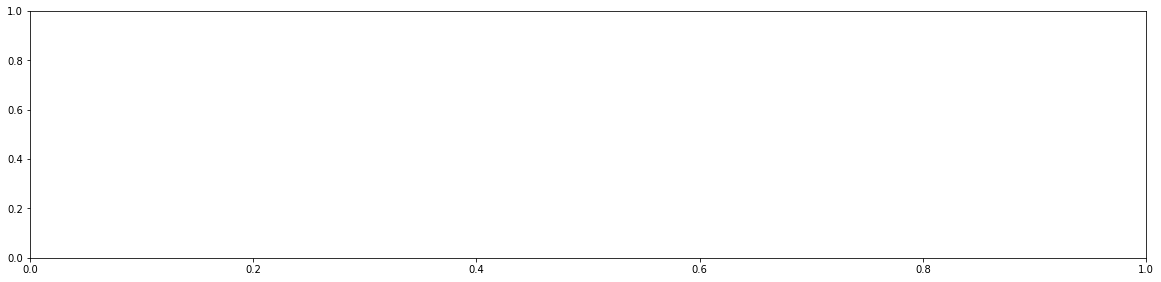

In [29]:
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(test_data, label='real')
    plt.plot(range(input_size, len(test_data)), pred, label='pred')
    plt.plot(range(input_size, len(test_data)), avg, label='mean')
    plt.legend(loc=1, framealpha=1, prop={'size': 20})
    plt.xlim([0, len(test_data)])
    plt.title('n = 30', fontsize=20)
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 2)
    plt.plot(test_data, label='real', linewidth=3)
    plt.plot(range(input_size, len(test_data)), pred, label='pred', linewidth=3)
    plt.plot(range(input_size, len(test_data)), avg, label='mean', linewidth=3)
    plt.legend(loc=1, framealpha=1, prop={'size': 20})
    plt.xlim([5450, 5500])
    plt.ylim([-50, 50])
    plt.show()


==> input_length:  2
==> train_error 11.489538606664604
==> error:  3.3522920594459746


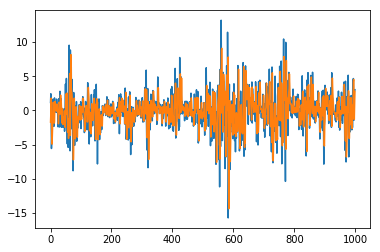


==> input_length:  3
==> train_error 11.009485905960679
==> error:  3.2105894550006484


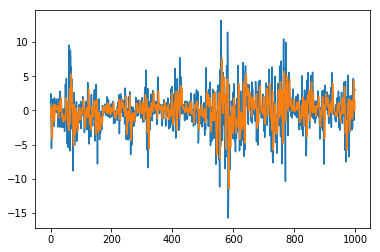


==> input_length:  5
==> train_error 10.16257611896268
==> error:  3.085495122511027


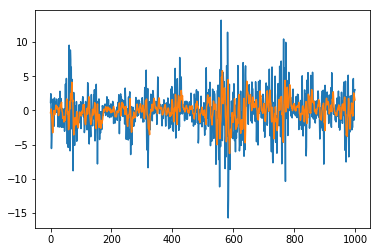


==> input_length:  10
==> train_error 9.756067211976964
==> error:  2.915961418537943


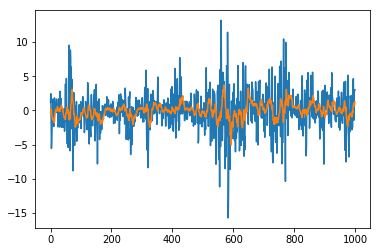


==> input_length:  20
==> train_error 9.177193877065267
==> error:  2.82990218922041


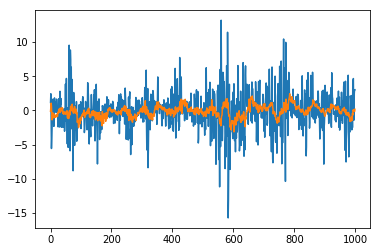


==> input_length:  30
==> train_error 9.023907060441184
==> error:  2.8592672776261208


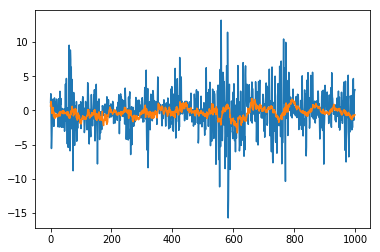


==> input_length:  40
==> train_error 9.161113726242792
==> error:  2.8275964049966955


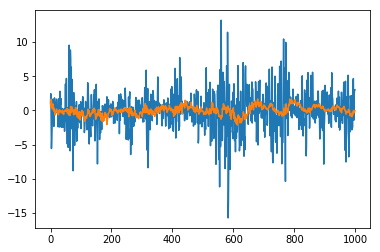


==> input_length:  50
==> train_error 9.139009568613329
==> error:  2.8246764804844835


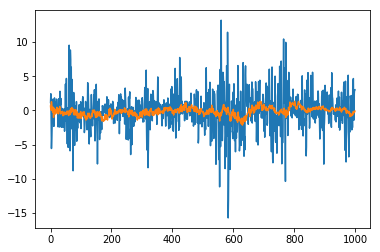


==> input_length:  60
==> train_error 9.099389093016802
==> error:  2.8039249170005536


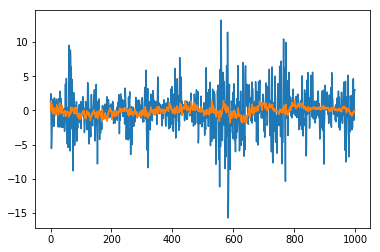


==> input_length:  70
==> train_error 8.891824129756147
==> error:  2.829141803172117


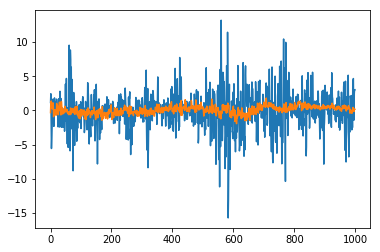


==> input_length:  80
==> train_error 8.86075794448472
==> error:  2.8230992053814634


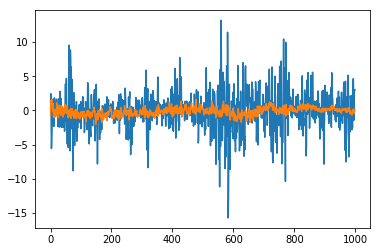


==> input_length:  90
==> train_error 9.304450853810529
==> error:  2.805745651926954


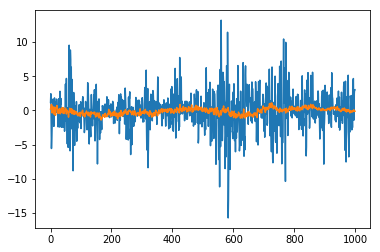


==> input_length:  100
==> train_error 7.818156253881131
==> error:  2.8497829755296795


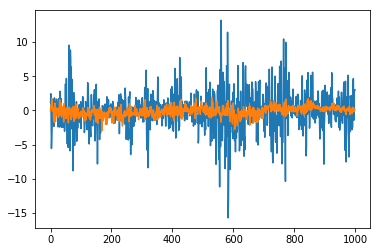

In [342]:
for input_size in [2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
    data1 = []
    for row in file:
        if len(row[0]) == 16:
            data1.append((float(row[3]) + float(row[4]))/2)

    data_delta = []
    for i in range(len(data1)-1):
        data_delta.append(data1[i+1]-data1[i])
    data1 = data_delta


    file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
    data2 = []
    for row in file:
        if len(row[0]) == 16:
            data2.append((float(row[3]) + float(row[4]))/2)
    end_point = len(data1)-1000

    data_delta = []
    for i in range(len(data2)-1):
        data_delta.append(data2[i+1]-data2[i])
    data2 = data_delta

    # one dimension
    data = data1
    x = torch.Tensor(end_point - input_size, input_size)
    x2 = torch.Tensor(end_point - input_size, input_size)
    y = torch.Tensor(end_point - input_size, 1)
    for step in range(end_point - input_size):
        sequence = np.array(data[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x[step, :] = torch.from_numpy(sequence[:-1])
#         y[step, :] = torch.FloatTensor([sequence[-1]])
    for step in range(end_point - input_size):
        sequence = np.array(data2[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x2[step, :] = torch.from_numpy(sequence[:-1])
        y[step, :] = torch.FloatTensor([sequence[-1]])
    max_seq = torch.max(x.abs())
    avg_seq2 = torch.mean(x2)
    x2 = x2 - avg_seq2
    max_seq2 = torch.max(x2.abs())
    x = x / max_seq
    y = (y-avg_seq2) / max_seq2
    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    model = ANN(input_size)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_error = 0
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs).view(-1, inputs.size(1)), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
            train_error += torch.pow((outputs-targets), 2).data.sum() * np.power(max_seq2, 2)
        train_loss /= len(train_loader)
        train_error /= end_point - input_size
        scheduler.step(train_loss)
        epoch += 1
    print('==> train_error', np.sqrt(train_error))
    pred = []
    error = []
    start_point = end_point - input_size
    test_data = data[start_point:]
    test_data2 = data2[start_point:]
    for step in range(len(test_data)-input_size):
        seq = np.array(test_data[step : step+input_size+1])
        avg_seq = np.mean(seq[:-1])
        seq = (seq - avg_seq)/max_seq

        seq2 = np.array(test_data2[step : step+input_size+1])
        avg_seq2 = np.mean(seq2[:-1])
        seq2 = (seq2 - avg_seq2)/max_seq2

        x_np = seq[:-1]
        y_np = seq[-1]
        x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        pred.append(avg_seq2+max_seq2*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.sqrt(np.mean([np.power(a-b, 2) for a, b in zip(test_data2[input_size:], pred)])))
    plt.plot(test_data2[input_size:])
    plt.plot(pred)
    plt.show()

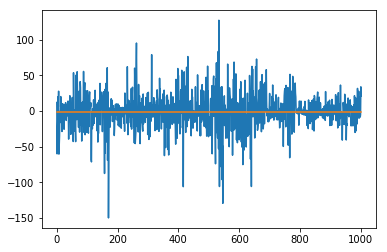

999 1000


In [266]:
plt.plot(test_data)
plt.plot(pred)
plt.show()
print(len(test_data[input_size:]), len(pred))

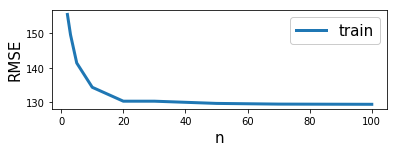

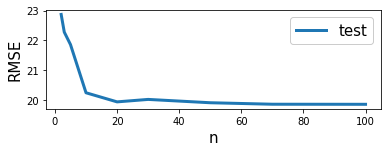

In [28]:

x = [2, 3, 5, 10, 20, 30, 50, 70, 100]
train = [155.5012906222249, 149.59651381050585, 141.4049528748728, 134.34992569800892,
         130.31189313160814, 130.31403424704564, 129.6705231165398, 129.46942513793866, 129.40986036719718]
test = [22.873824798589627, 22.280920525400116, 21.86203618443362, 20.24274605639211, 19.936954204322262,
       20.019382611348664, 19.907661572767832, 19.857632508094653, 19.855001839430372]

plt.subplot(2, 1, 1)
plt.plot(x, train, label='train', linewidth=3)
plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.xlabel('n', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.show()

plt.subplot(2, 1, 2)
plt.plot(x, test, label='test', linewidth=3)
plt.legend(loc=1, framealpha=1, prop={'size': 15})
plt.xlabel('n', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.show()

### LSTM

In [5]:
# ETH + BTC => BTC
for input_size in [2, 3, 5, 10, 20, 30, 50, 70, 100]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
    data1 = []
    for row in file:
        if len(row[0]) == 16:
            data1.append(float(row[5]))

    file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
    data2 = []
    for row in file:
        if len(row[0]) == 16:
            data2.append(float(row[5]))

    data_delta = []
    for i in range(len(data1)-1):
        data_delta.append(data1[i+1]-data1[i])
    data1 = data_delta

    data_delta = []
    for i in range(len(data2)-1):
        data_delta.append(data2[i+1]-data2[i])
    data2 = data_delta

    end_point = len(data1)-1000

    # data = (data - np.mean(data))/np.max(np.abs(data))
    x = torch.Tensor(end_point - input_size, input_size, 2)
    y = torch.Tensor(end_point - input_size, 1)
    avg1_seq = np.mean(data1[:end_point])
    max1_seq = np.max(np.abs(data1[:end_point]))

    avg2_seq = np.mean(data2[:end_point])
    max2_seq = np.max(np.abs(data2[:end_point]))
    for step in range(end_point - input_size):
        x[step, :, 0] = torch.from_numpy((np.array(data1[step : step + input_size])-avg1_seq)/max1_seq)
        x[step, :, 1] = torch.from_numpy((np.array(data2[step : step + input_size])-avg2_seq)/max2_seq)
        y[step, :] = torch.FloatTensor([data1[step+input_size]])
    y = (y - avg1_seq) / max1_seq

    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    model = LSTM(2)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
        train_loss /= len(train_loader)
        scheduler.step(train_loss)
        epoch += 1

    pred = []
    error = []
    start_point = 4780
    test_data1 = data1[start_point:]
    test_data2 = data2[start_point:]
    x_np = np.zeros((1, input_size, 2))
    for step in range(len(test_data)-input_size):

        y_np = (np.array(test_data1[step+input_size]) - avg1_seq)/max1_seq
        x_np[0, :, 0] = (np.array(test_data1[step : step + input_size])-avg1_seq)/max1_seq
        x_np[0, :, 1] = (np.array(test_data2[step : step + input_size])-avg2_seq)/max2_seq
        x = Variable(torch.from_numpy(x_np)).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        pred.append(avg1_seq+max1_seq*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.mean([np.power(a-b, 2) for a, b in zip(test_data1[input_size:], pred)]))


==> input_length:  2


NameError: name 'test_data' is not defined


==> input_length:  2
==> train_error 155.48448498411236
==> error:  22.869227649540473


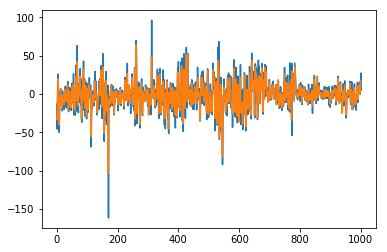


==> input_length:  3
==> train_error 149.59911378176446
==> error:  22.297295159429037


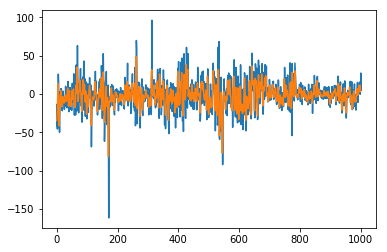


==> input_length:  5
==> train_error 141.4710938613423
==> error:  22.31909601815374


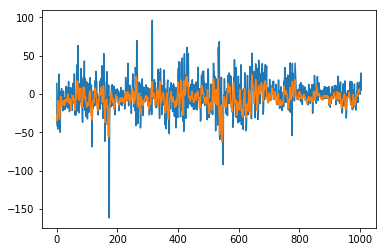


==> input_length:  10
==> train_error 134.35087497414895
==> error:  20.243734954613583


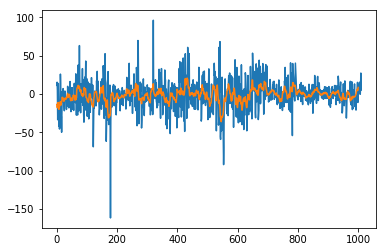


==> input_length:  20
==> train_error 130.31395148947527
==> error:  19.937635232110278


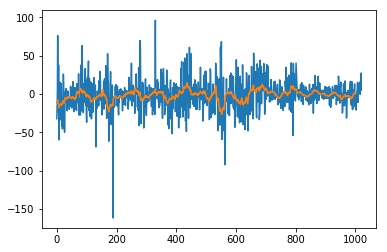


==> input_length:  30
==> train_error 130.32009270580463
==> error:  20.03332168778947


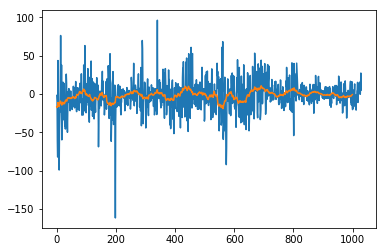


==> input_length:  50
==> train_error 129.66508320796203
==> error:  19.90918934705022


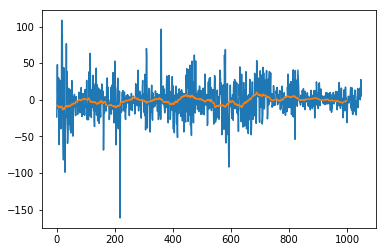


==> input_length:  70
==> train_error 129.46533758367474
==> error:  19.855631716314726


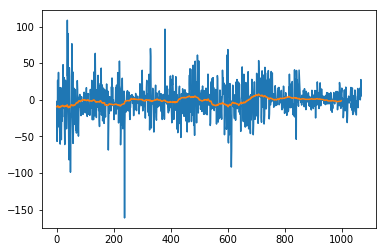


==> input_length:  100
==> train_error 129.40459006887664
==> error:  19.855489434653276


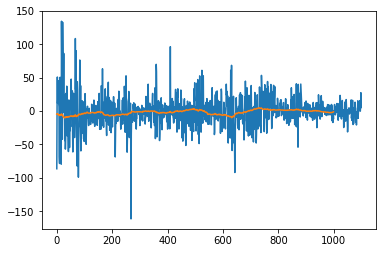

In [6]:
# BTC => BTC
for input_size in [2, 3, 5, 10, 20, 30, 50, 70, 100]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
    data1 = []
    for row in file:
        if len(row[0]) == 16:
            data1.append((float(row[3]) + float(row[4]))/2)

    data_delta = []
    for i in range(len(data1)-1):
        data_delta.append(data1[i+1]-data1[i])
    data1 = data_delta

    file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
    data2 = []
    for row in file:
        if len(row[0]) == 16:
            data2.append((float(row[3]) + float(row[4]))/2)
    end_point = len(data1)-1000

    data_delta = []
    for i in range(len(data2)-1):
        data_delta.append(data2[i+1]-data2[i])
    data2 = data_delta

    data = data1
    end_point = len(data) - 1000
    # data = (data - np.mean(data))/np.max(np.abs(data))
    x = torch.Tensor(end_point - input_size, input_size)
    y = torch.Tensor(end_point - input_size, 1)
    for step in range(end_point - input_size):
        sequence = np.array(data[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x[step, :] = torch.from_numpy(sequence[:-1])
        y[step, :] = torch.FloatTensor([sequence[-1]])
    max_seq = torch.max(x.abs())
    x = x / max_seq
    y = y / max_seq
    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    
    model = LSTM(1)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_loss = 0
        train_error = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
            train_error += torch.pow((outputs-targets), 2).data.sum() * np.power(max_seq, 2)
        train_loss /= len(train_loader)
        train_error /= end_point - input_size
        scheduler.step(train_loss)
        epoch += 1
    print('==> train_error', np.sqrt(train_error))
    pred = []
    error = []
    start_point = end_point - input_size
    test_data = data[start_point:]
    for step in range(len(test_data)-input_size):
        seq = np.array(test_data[step : step+input_size+1])
        avg_seq = np.mean(seq[:-1])
        seq = (seq - avg_seq)/max_seq

        x_np = seq[:-1]
        y_np = seq[-1]
        x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.sqrt(np.mean([np.power(a-b, 2) for a, b in zip(test_data[input_size:], pred)])))
    plt.plot(test_data)
    plt.plot(pred)
    plt.show()


==> input_length:  2
==> train_error 11.489599832371617
==> error:  3.3518954683403894


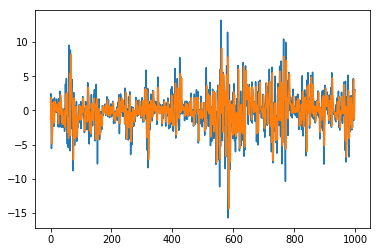


==> input_length:  3
==> train_error 10.990018872370076
==> error:  3.2108262376804175


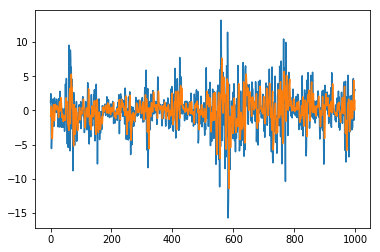


==> input_length:  5
==> train_error 10.158176482087695
==> error:  3.0984768273713685


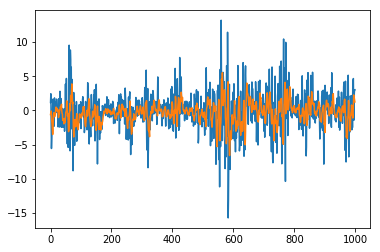


==> input_length:  10
==> train_error 9.75871164635075
==> error:  2.9138983326731425


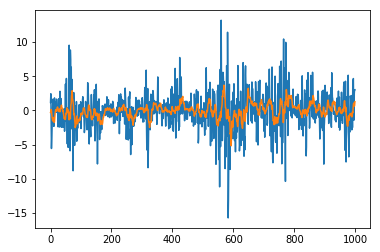


==> input_length:  20
==> train_error 9.434677822704337
==> error:  2.852498918346086


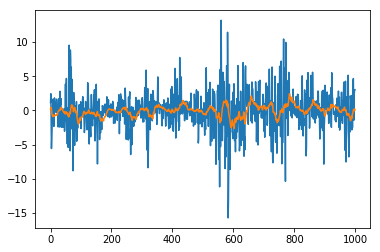


==> input_length:  30
==> train_error 9.462086231601235
==> error:  2.8620410471217457


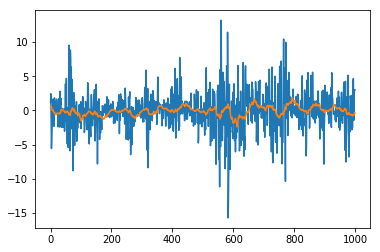


==> input_length:  50
==> train_error 9.42966594736131
==> error:  2.8340377583144094


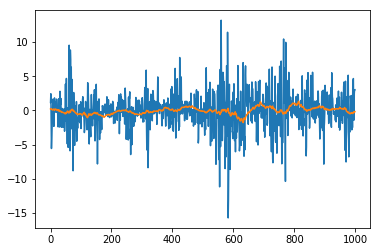


==> input_length:  70
==> train_error 9.402592091727248
==> error:  2.828549769650434


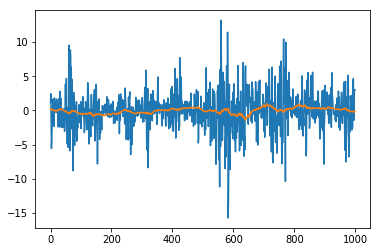


==> input_length:  100
==> train_error 9.414171947533626
==> error:  2.8191357057326645


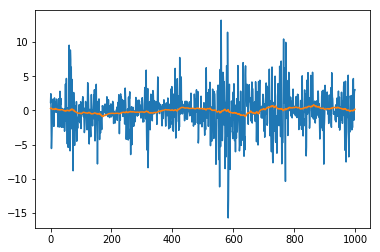

In [340]:
for input_size in [2, 3, 5, 10, 20, 30, 50, 70, 100]:
    print('\n==> input_length: ', input_size)
    file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
    data1 = []
    for row in file:
        if len(row[0]) == 16:
            data1.append((float(row[3]) + float(row[4]))/2)

    data_delta = []
    for i in range(len(data1)-1):
        data_delta.append(data1[i+1]-data1[i])
    data1 = data_delta


    file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
    data2 = []
    for row in file:
        if len(row[0]) == 16:
            data2.append((float(row[3]) + float(row[4]))/2)
    end_point = len(data1)-1000

    data_delta = []
    for i in range(len(data2)-1):
        data_delta.append(data2[i+1]-data2[i])
    data2 = data_delta

    # one dimension
    data = data1
    x = torch.Tensor(end_point - input_size, input_size)
    x2 = torch.Tensor(end_point - input_size, input_size)
    y = torch.Tensor(end_point - input_size, 1)
    for step in range(end_point - input_size):
        sequence = np.array(data[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x[step, :] = torch.from_numpy(sequence[:-1])
#         y[step, :] = torch.FloatTensor([sequence[-1]])
    for step in range(end_point - input_size):
        sequence = np.array(data2[step : step + input_size + 1])
        sequence = (sequence - np.mean(sequence[:-1]))
        x2[step, :] = torch.from_numpy(sequence[:-1])
        y[step, :] = torch.FloatTensor([sequence[-1]])
    max_seq = torch.max(x.abs())
    avg_seq2 = torch.mean(x2)
    x2 = x2 - avg_seq2
    max_seq2 = torch.max(x2.abs())
    x = x / max_seq
    y = (y-avg_seq2) / max_seq2
    train_set = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
    model = LSTM(1)
    model.cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
    loss_func = nn.MSELoss()
    epoch = 0
    while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
        train_error = 0
        train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda().float()
            inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
            train_error += torch.pow((outputs-targets), 2).data.sum() * np.power(max_seq2, 2)
        train_loss /= len(train_loader)
        train_error /= end_point - input_size
        scheduler.step(train_loss)
        epoch += 1
    print('==> train_error', np.sqrt(train_error))
    pred = []
    error = []
    start_point = end_point - input_size
    test_data = data[start_point:]
    test_data2 = data2[start_point:]
    for step in range(len(test_data)-input_size):
        seq = np.array(test_data[step : step+input_size+1])
        avg_seq = np.mean(seq[:-1])
        seq = (seq - avg_seq)/max_seq

        seq2 = np.array(test_data2[step : step+input_size+1])
        avg_seq2 = np.mean(seq2[:-1])
        seq2 = (seq2 - avg_seq2)/max_seq2
        
        x_np = seq[:-1]
        y_np = seq2[-1]
        x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
        y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

        prediction = model(x)

        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        pred.append(avg_seq2+max_seq2*prediction.cpu().data.sum())
        error.append(loss.cpu().data.sum())

    # plot prediction
    print('==> error: ', np.sqrt(np.mean([np.power(a-b, 2) for a, b in zip(test_data2[input_size:], pred)])))
    plt.plot(test_data2[input_size:])
    plt.plot(pred)
    plt.show()


==> input_length:  2
==> train_error 127.8100249199171
==> error:  22.883425


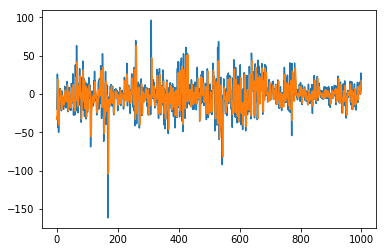


==> input_length:  3


KeyboardInterrupt: 

In [70]:
# BTC => BTC, cross validation
num_sec = 5
ss = len(data) // num_sec # shift step
ss = 1000
for sf in [0]: # range(num_sec)
    sf *= num_sec
    for input_size in [2, 3, 5, 10, 20, 30, 50, 70, 100]:
        print('\n==> input_length: ', input_size)
        file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
        data1 = []
        for row in file:
            if len(row[0]) == 16:
                data1.append((float(row[3]) + float(row[4]))/2)

        data_delta = []
        for i in range(len(data1)-1):
            data_delta.append(data1[i+1]-data1[i])
        data1 = data_delta

        file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
        data2 = []
        for row in file:
            if len(row[0]) == 16:
                data2.append((float(row[3]) + float(row[4]))/2)

        data_delta = []
        for i in range(len(data2)-1):
            data_delta.append(data2[i+1]-data2[i])
        data2 = data_delta

        data = data1

        # data = (data - np.mean(data))/np.max(np.abs(data))
        x = torch.Tensor(len(data) - input_size, input_size)
        y = torch.Tensor(len(data) - input_size, 1)
        avg_seq = []
        for step in range(len(data) - input_size):
            sequence = np.array(data[step : step + input_size + 1])
            x[step, :] = torch.from_numpy(sequence[:-1])
            y[step, :] = torch.FloatTensor([sequence[-1]])
        if sf:
            test_x = x[-ss-sf:-sf, :]
            test_y = y[-ss-sf:-sf, :]
            train_x = torch.cat((x[:-ss-sf,:], x[-sf:,:]), 0)
            train_y = torch.cat((y[:-ss-sf,:], y[-sf:,:]), 0)
        else:
            test_x = x[-ss:, :]
            test_y = y[-ss:, :]
            train_x = x[:-ss]
            train_y = y[:-ss]
        train_x = train_x - torch.mean(train_x, 1).view(-1, 1)
        train_y = train_y - torch.mean(train_x, 1).view(-1, 1)
        max_seq = torch.max(train_x.abs())
        train_x = train_x / max_seq
        train_y = train_y / max_seq
        train_set = torch.utils.data.TensorDataset(train_x, train_y)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

        model = LSTM(1)
        model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=False, patience=10)
        loss_func = nn.MSELoss()
        epoch = 0
        while optimizer.state_dict()['param_groups'][0]['lr'] > 1e-4:
            train_loss = 0
            train_error = 0
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.cuda(), targets.cuda().float()
                inputs, targets = Variable(inputs).view(-1, inputs.size(1), 1), Variable(targets)
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.data[0]
                train_error += torch.pow((outputs-targets), 2).data.sum() * np.power(max_seq, 2)
            train_loss /= len(train_loader)
            train_error /= end_point - input_size
            scheduler.step(train_loss)
            epoch += 1
        print('==> train_error', np.sqrt(train_error))
        pred = []
        error = []
        start_point = end_point - input_size
        test_data = data[start_point:]
        for step in range(test_x.size(0)):
            seq = test_x[step, :]
            avg_seq = torch.mean(seq)
            seq = (seq-avg_seq) / max_seq

            x = Variable(seq).float().cuda().view(-1, inputs.size(1), 1)
            y = Variable((test_y[step, :] - avg_seq) / max_seq).float().cuda()

            prediction = model(x)

            loss = loss_func(prediction, y)
            optimizer.zero_grad()
            pred.append(avg_seq+max_seq*prediction.cpu().data.sum())
            error.append(loss.cpu().data.sum())

        # plot prediction
        print('==> error: ', np.sqrt(np.mean([np.power(a-b, 2) for a, b in zip(test_y.numpy(), pred)])))
        plt.plot(test_y.numpy())
        plt.plot(pred)
        plt.show()

In [33]:
ss = len(data)/5 # shift step
sf = 0 # shift factor
input_size = 20
print('\n==> input_length: ', input_size)
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h_new.csv','r'))
data1 = []
for row in file:
    if len(row[0]) == 16:
        data1.append((float(row[3]) + float(row[4]))/2)

data_delta = []
for i in range(len(data1)-1):
    data_delta.append(data1[i+1]-data1[i])
data1 = data_delta

file=csv.reader(open('../svm/matlab/Gdax_ETHUSD_1h_new.csv','r'))
data2 = []
for row in file:
    if len(row[0]) == 16:
        data2.append((float(row[3]) + float(row[4]))/2)

data_delta = []
for i in range(len(data2)-1):
    data_delta.append(data2[i+1]-data2[i])
data2 = data_delta

data = data1

# data = (data - np.mean(data))/np.max(np.abs(data))
x = torch.Tensor(len(data) - input_size, input_size)
y = torch.Tensor(len(data) - input_size, 1)
for step in range(len(data) - input_size):
    sequence = np.array(data[step : step + input_size + 1])
    sequence = (sequence - np.mean(sequence[:-1]))
    x[step, :] = torch.from_numpy(sequence[:-1])
    y[step, :] = torch.FloatTensor([sequence[-1]])
    if sf:
        test_x = x[-ss-sf:-sf, :]
        test_y = y[-ss-sf:-sf, :]
        train_x = torch.cat((x[:-ss-sf,:], x[-sf:,:]), 0)
        train_y = torch.cat((y[:-ss-sf,:], y[-sf:,:]), 0)
    else:
        test_x = x[-ss:, :]
        test_y = y[-ss:, :]
        train_x = x[:-ss]
        train_y = y[:-ss]


==> input_length:  20


In [63]:
train_x -torch.mean(train_x, 1)

RuntimeError: inconsistent tensor size, expected r_ [4694 x 2], t [4694 x 2] and src [4694] to have the same number of elements, but got 9388, 9388 and 4694 elements respectively at /pytorch/torch/lib/TH/generic/THTensorMath.c:887

In [68]:
len(pred)

1174

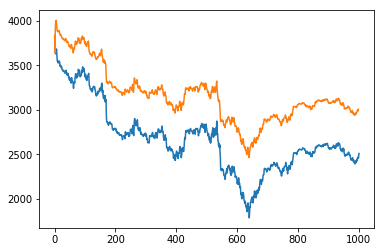

999 1000


8663.70608704578

In [279]:
plt.plot(test_data)
plt.plot(pred)
plt.show()
print(len(test_data[input_size:]), len(pred))
avg_seq

## Other experiments

epoch: 200
epoch: 400
epoch: 600
epoch: 800
epoch: 1000
epoch: 1200
epoch: 1400
epoch: 1600
epoch: 1800
epoch: 2000
epoch: 2200
epoch: 2400
epoch: 2600
epoch: 2800
epoch: 3000
epoch: 3200
epoch: 3400
epoch: 3600
epoch: 3800


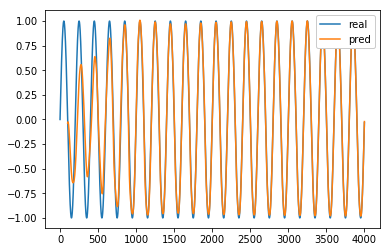

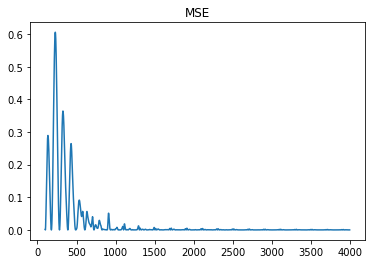

In [158]:
model = LSTM()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

# data collection
data = np.arange(4000)
data = data * np.pi / 100
data = np.sin(data)

pred = []
error = []
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()
    prediction = model(x)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, len(data)), error)
plt.title('MSE')
plt.show()

epoch: 200
epoch: 400
epoch: 600
epoch: 800


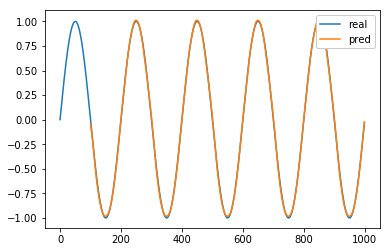

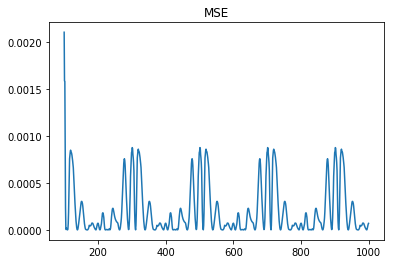

In [159]:
data = np.arange(1000)
data = data * np.pi / 100
data = np.sin(data)
model.eval()
pred = []
error = []
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, np.newaxis, :])).float().cuda()
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()
    prediction = model(x)

    loss = loss_func(prediction, y)
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, len(data)), error)
plt.title('MSE')
plt.show()

epoch: 200
epoch: 400
epoch: 600
epoch: 800


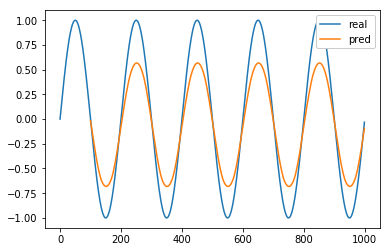

epoch: 200
epoch: 400
epoch: 600
epoch: 800


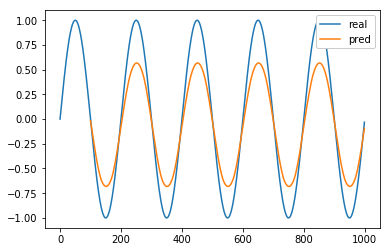

In [84]:
pred = []
data = data[0:1000]
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, h_state)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
#     optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

pred = []
data = data[0:1000]
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, None)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
#     optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

In [47]:
x = Variable(torch.Tensor(3,2,1)).cuda()

In [115]:
np.mean([x * np.power(max_value,2) for x in error[4000:]])

17538.790885794217

In [202]:
y


-1.4437e-10
 4.5602e-41
 6.7544e-04
     ⋮     
 0.0000e+00
 6.2078e-43
 0.0000e+00
[torch.FloatTensor of size 5580]

In [229]:
model = LSTM(1)
model.cuda()
for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=True).view(-1, 100, 1), Variable(targets)
    outputs = model(inputs).view(-1)

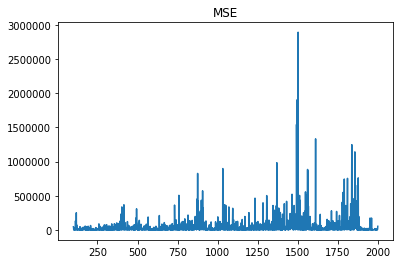

In [18]:
model = RNN()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=2e-4)
loss_func = nn.MSELoss()

# data collection
import csv
file=csv.reader(open('../svm/matlab/Gdax_BTCUSD_1h.csv','r'))
data = []
for row in file:
    if len(row[0]) == 16:
        data.append(float(row[5]))

h_state = None # initialize

length = 2000
pred = []
error2 = []
for step in range(length - 100):
    prediction = data[step + 99]
    y_np = data[step + 100]

    loss = pow(prediction - y_np, 2)
    error2.append(loss)

# # plot error
# plt.plot(range(100, length), [a_i - b_i for a_i, b_i in zip(error, error2)])
plt.plot(range(100, length), error2)
plt.title('MSE')
plt.show()

epoch: 200
epoch: 400
epoch: 600
epoch: 800
epoch: 1000
epoch: 1200
epoch: 1400
epoch: 1600
epoch: 1800


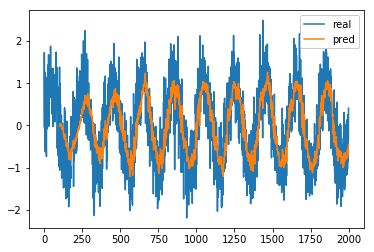

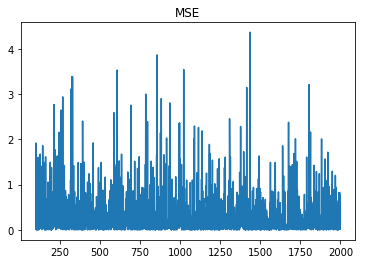

In [27]:

model = RNN()
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=2e-4)
loss_func = nn.MSELoss()

# data collection
data = np.arange(2000)
data = data * np.pi / 100
data = np.sin(data) + np.random.normal(0, 0.5, 2000)

h_state = None # initialization

pred = []
error = []
for step in range(len(data)-100):
    if step % 200 == 199:
        print('epoch:', step + 1)
    x_np = np.array(data[step : step + 100])
    y_np = np.array(data[step + 100])
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).float().cuda()
    y = Variable(torch.from_numpy(np.reshape(y_np, (1, 1, 1)))).float().cuda()

    prediction, h_state = model(x, h_state)
    h_state = Variable(h_state.data)

    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred.append(prediction.cpu().data.sum())
    error.append(loss.cpu().data.sum())

# plot prediction
plt.plot(np.array(data), label='real')
p = plt.plot(range(100, len(data)), pred, label='pred')
plt.legend(loc=1, framealpha=1)
plt.show()

# plot error
plt.plot(range(100, len(data)), error)
plt.title('MSE')
plt.show()